In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [2]:
# Loading the datasets
train_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_Train.csv')
test_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_test.csv')
validation_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_Validation.csv')

In [3]:
# Function for preprocessing the datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [4]:
# Preprocessing all datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

In [5]:
def add_lagged_features(df, n_lags=3):
    for lag in range(1, n_lags + 1):
        df[f'Average_Temp_lag_{lag}'] = df['Average_Temp'].shift(lag)
    return df.dropna().reset_index(drop=True)

train_df = add_lagged_features(train_df)
validation_df = add_lagged_features(validation_df)
test_df = add_lagged_features(test_df)

In [7]:

def get_features_targets(df):
    feature_cols = ['Year', 'Month', 'Day', 'Hour', 'Average_Temp'] + [f'Average_Temp_lag_{lag}' for lag in range(1, 4)]  # Assuming 3 lags
    X = df[feature_cols]
    y = df['MW']
    return X, y


X_train, y_train = get_features_targets(train_df)
X_validation, y_validation = get_features_targets(validation_df)
X_test, y_test = get_features_targets(test_df)

In [8]:
# Evaluating Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Ignoring negative actual values if considered invalid
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # MAE and RMSE calculation
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # MAPE will be capped at 100 if it goes above 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    # sMAPE Calculation
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from joblib import dump


# Pipeline for preprocessing and modeling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Grid of parameters to search
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 4, 5]
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1)

grid_search.fit(X_train, y_train)

# Getting the Best model
best_model_gradient = grid_search.best_estimator_

# Save the model to a file
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_Gradient_Boost_model_V2.joblib'
dump(best_model_gradient, model_filename)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


['/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_Gradient_Boost_model_V2.joblib']

In [9]:
from joblib import load
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_Gradient_Boost_model_V2.joblib'

loaded_best_model_gradient = load(model_filename)


In [10]:
gradient_boosting_model = loaded_best_model_gradient.named_steps['model']

# Now, print the best parameters
print("Best parameters for the loaded Gradient Boosting model:")
print(f"n_estimators: {gradient_boosting_model.n_estimators}")
print(f"learning_rate: {gradient_boosting_model.learning_rate}")
print(f"max_depth: {gradient_boosting_model.max_depth}")

Best parameters for the loaded Gradient Boosting model:
n_estimators: 100
learning_rate: 0.1
max_depth: 3


In [10]:
# Predicting on the validation set using the best model
predictions_validation = loaded_best_model_gradient.predict(X_validation)
metrics_validation = calculate_metrics(y_validation, predictions_validation)
print("Validation Metrics after tuning (MAE, MAPE, sMAPE,RMSE):", metrics_validation)


Validation Metrics after tuning (MAE, MAPE, sMAPE,RMSE): (49.560473933634626, 60.26458481820884, 61.517206755914955, 76.72930633371936)


In [12]:
# Evaluating on the test set
predictions_test = loaded_best_model_gradient.predict(X_test)
metrics_test = calculate_metrics(y_test, predictions_test)

print("Test Metrics with Gradient Boosting (MAE, MAPE, sMAPE, RMSE):", metrics_test)

Test Metrics with Gradient Boosting (MAE, MAPE, sMAPE, RMSE): (22.090814188145593, 25.85913867616182, 32.63272827040997, 40.88787362542577)


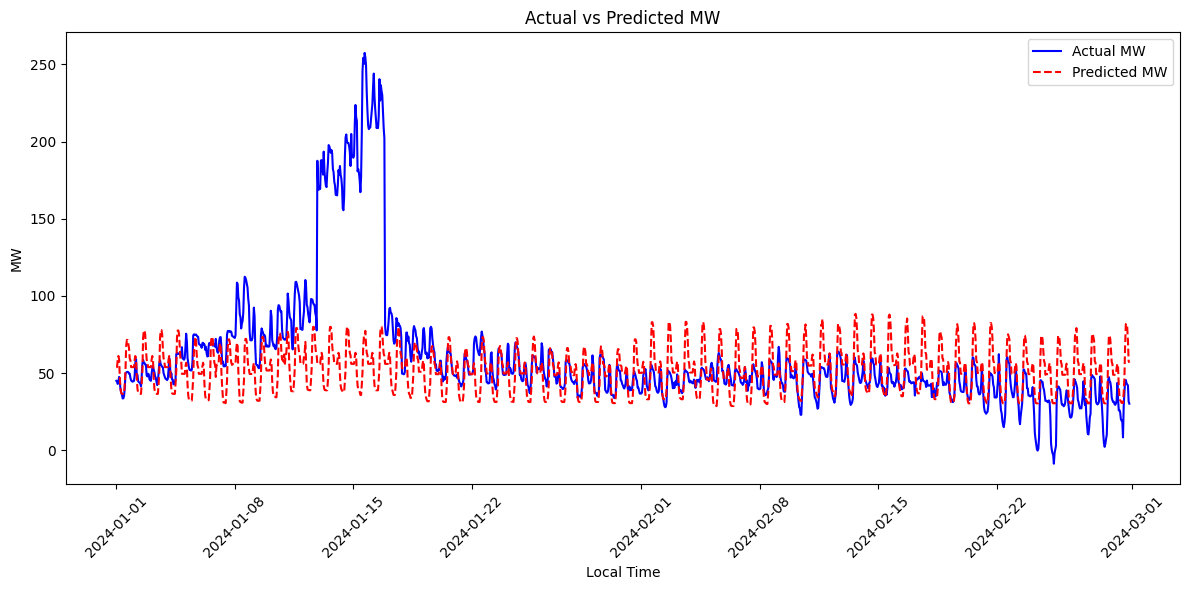

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading the 'local_time' column from the test dataset again
test_df_for_plotting = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

# Ensuring the length of test_local_time matches y_test_pred and y_test
if len(test_local_time) > len(predictions_test):
    test_local_time = test_local_time[:len(predictions_test)]

plt.figure(figsize=(12, 6))
plt.plot(test_local_time, y_test[:len(test_local_time)], label='Actual MW', color='blue') 
plt.plot(test_local_time, predictions_test, label='Predicted MW', color='red', linestyle='--')
plt.title('Actual vs Predicted MW')
plt.xlabel('Local Time')
plt.ylabel('MW')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Evaluate the best model on the training set
y_train_pred = loaded_best_model_gradient.predict(X_train)  # Predicting on the training features
train_metrics = calculate_metrics(y_train, y_train_pred)
print(f"Training Metrics: MAE={train_metrics[0]}, MAPE={train_metrics[1]}, sMAPE={train_metrics[2]}, RMSE={train_metrics[3]}")

# Comparing the metrics
print("Comparing Training, Validation, and Test Metrics:")
print("Training: ", train_metrics)
print("Validation: ", metrics_validation)
print("Test: ", metrics_test)


Training Metrics: MAE=12.838480184044391, MAPE=19.86356336838031, sMAPE=19.696847145065938, RMSE=26.754151059980735
Comparing Training, Validation, and Test Metrics:
Training:  (12.838480184044391, 19.86356336838031, 19.696847145065938, 26.754151059980735)
Validation:  (49.560473933634626, 60.26458481820884, 61.517206755914955, 76.72930633371936)
Test:  (22.090814188145593, 25.85913867616182, 32.63272827040997, 40.88787362542577)
